In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import traceback
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from skfeature.function.similarity_based import fisher_score


In [2]:
data = pd.read_csv(r"C:\Users\Rosco\OneDrive - James Cook University\Documents\Scripts\Bruker_preprocessed_sizeOrder.csv")

# remove last 50 columns due to noise from preprocessing
data = data.iloc[:,:-50] 

# make even category counts
print(data['species'].value_counts())
data=data.groupby('species',as_index = False,group_keys=False).apply(lambda s: s.sample(50,replace=False)) 
print(data['species'].value_counts())

## change wavenumber to wavelength
columnlabels = data.columns.values.tolist()
for i, item in enumerate(columnlabels):
    try: 
       wn = 10000000/float(item)
       wn = str(round(wn, 3))

       columnlabels[i] =  wn
    except Exception:
        pass
        # traceback.print_exc()
data.columns  = columnlabels #


#sort and reset row index  
data = data.sort_values(by=['classInt'])
data.reset_index(drop=True, inplace=True)


datasmall = data.drop(data[data.classInt > 4].index)


# select X and y 
X = data.values[:,5:].astype(float)
y = data['classInt'].to_numpy()


# set up various bits for plotting
labels = data.label.unique()
classInt = data.classInt.unique()
sizegroup = data.groupby('classInt')
df2 = sizegroup.apply(lambda x: x['sizes'].unique().item())
sizes = df2.to_numpy()


font = {'fontname':'Calibri'}
colors = plt.cm.tab10(np.linspace(0,1,10))


# data.to_csv(r"C:\Users\Rosco\OneDrive - James Cook University\Documents\Scripts\test.csv")



Anoplolepis      141
Carebara          57
Polyrhachis       52
Pheidole          50
Tetramorium       50
Crematogaster     50
Colobopsis        50
Camponotus        50
Oecophylla        50
Name: species, dtype: int64
Anoplolepis      50
Camponotus       50
Carebara         50
Colobopsis       50
Crematogaster    50
Oecophylla       50
Pheidole         50
Polyrhachis      50
Tetramorium      50
Name: species, dtype: int64


SPECTRA PLOT

C:\Users\Rosco\AppData\Local\Temp\ipykernel_27860\2552834254.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average = grouped.mean()


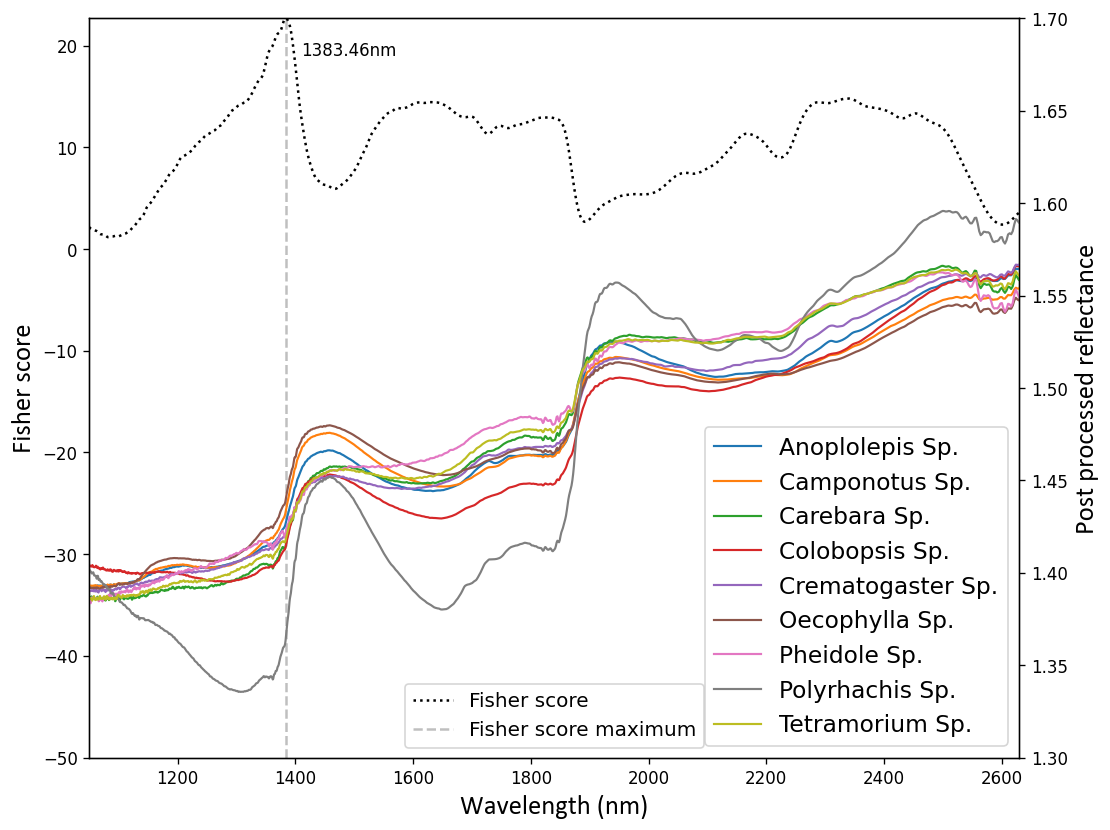

In [4]:
fig = plt.figure(dpi=120, figsize=(10,8))
plt.gcf().set_dpi(120)
plt.style.use('default')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()


grouped = data.groupby('species')
average = grouped.mean()
wl = list(average.columns[2:].astype('float32'))


fish = fisher_score.fisher_score(X, y) #returns rank directly instead of fisher score. so no need for feature_ranking
fishsmoothed = gaussian_filter1d(fish, sigma=5)
curve= ax1.plot(wl, fishsmoothed, linestyle='dotted', c='black')
ax1.axvline(x = wl[np.argmax(fishsmoothed[:])], color = 'gray', alpha=0.5, linestyle='dashed')


i=0
legend = []
for index, row in average.iterrows():
    specie = data.loc[data['species'] == index, 'label'].iloc[0]
    legend.append(specie+" Sp.")
    spectra = average.loc[index].to_numpy()
    ax2.plot(wl, (spectra[2:]), color=colors[i], linewidth=1.3)
    i = i+1

ax1.legend(['Fisher score', 'Fisher score maximum'], loc=8, prop= {"size":12})
ax2.legend(legend, loc=4, prop = { "size": 14 })
ax1.set_ylim([-50,np.max(fishsmoothed[:])])
ax2.set_xlim([1050,2630])
ax2.set_ylim([1.3,1.7])
ax1.annotate("%.2fnm" % wl[np.argmax(fishsmoothed[:-400])], xy=[1410,19])
ax1.set_xlabel("Wavelength (nm)",  **font, fontsize=16)
ax1.set_ylabel("Fisher score",  **font, fontsize=16)
ax2.set_ylabel("Post processed reflectance",  **font, fontsize=16)

plt.savefig('spectrafisher')
plt.show()

In [13]:
fig = plt.figure(dpi=120, figsize=(10,8))
plt.gcf().set_dpi(120)
plt.style.use('default')

grouped = data.groupby('species')
average = grouped.mean()
wl = list(data.columns[2:].astype('float32'))


i=0
legend = []
for index, row in data.iterrows():
    specie = row['species']
    legend.append(specie+" Sp.")
    plt.plot(wl, (row[5:]), color=colors[i], linewidth=1.3)


plt.show()

C:\Users\Rosco\AppData\Local\Temp\ipykernel_19624\2144284172.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average = grouped.mean()


TypeError: Cannot cast Index to dtype float32

<Figure size 1200x960 with 0 Axes>

PCA

C:\Users\Rosco\AppData\Local\Temp\ipykernel_27860\2284530869.py:36: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8


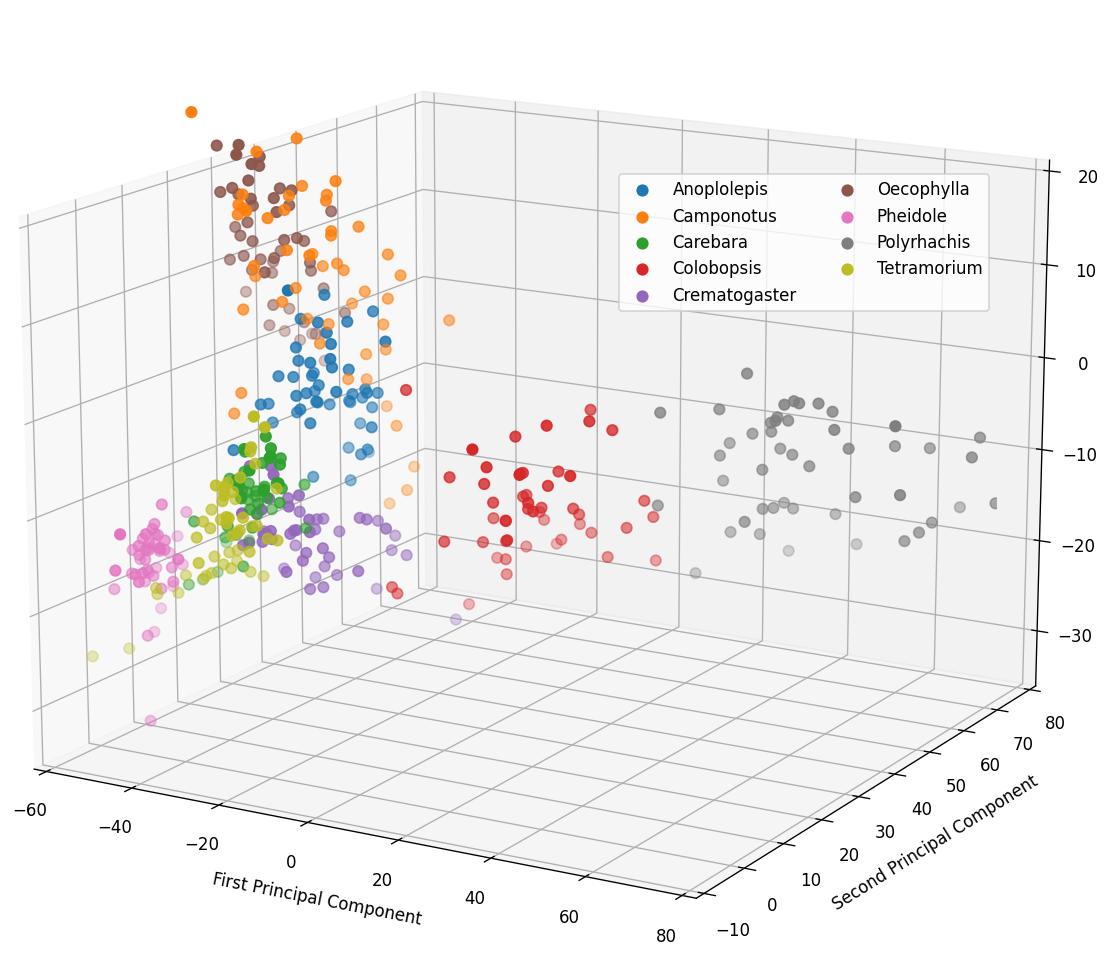

In [36]:
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X)

pca = PCA(n_components=3)
pca.fit(X_scaled) 
X_pca = pca.transform(X_scaled) 

# ex_variance=np.var(X_pca,axis=0)
# ex_variance_ratio = ex_variance/np.sum(ex_variance)
# ex_variance_ratio

Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]


fig = plt.figure(figsize=(10,8))
plt.gcf().set_dpi(120)
plt.style.use('default')
ax = fig.add_subplot(111, projection='3d')

for l in np.unique(data['species']):
 ix=np.where(data['species']==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], s=40, label=l)
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=10)
ax.set_ylabel("Second Principal Component", fontsize=10)
ax.set_zlabel("Third Principal Component", fontsize=10)
ax.axes.set_xlim3d(left=-60, right=80) 
ax.axes.set_ylim3d(bottom=-10, top=80) 
ax.axes.set_zlim3d(bottom=-35, top=20) 

ax.legend(loc='right', ncols=2, bbox_to_anchor=(1, 0.75), ncol=1)
ax.elev = 15    # x rotation (default=0)
ax.dist = 8
# ax.azim= 80

# ax.invert_xaxis()
# ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('PCABruker',dpi=fig.dpi)
plt.show()

PCA CUMULATIVE VARIANCE EXPLAINED

In [4]:

pca = PCA()
pca.fit(X)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)


fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)
fig.update_layout(xaxis_range=[1,50], height = 400, width = 700)


INTERACTIVE PCA

In [53]:
fig = plt.figure(figsize=(8,10))

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=data['species'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=800, height=800, size=data['sizes']
)
fig.show()

<Figure size 800x1000 with 0 Axes>

LDA LOOCV

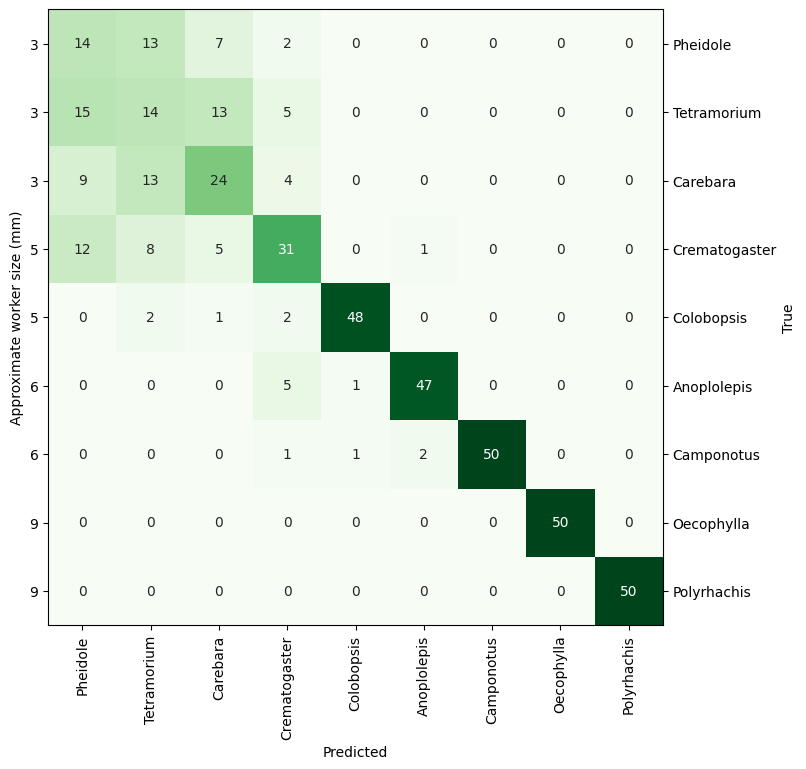

In [84]:
lda = LDA(n_components=3)
conf_matrix = pd.DataFrame(columns=list(range(1,1+len(labels))), index=list(range(1,1+len(labels))))
conf_matrix.loc[:,:] = 0

for index, row in data.iterrows():
    
        traindata = data.drop(index, axis=0)
        ytest = row['classInt']
        ytrain = traindata['classInt']
        Xtest = row.values[3:].astype(float)
        Xtrain = traindata.values[:,3:].astype(float)

        lda.fit_transform(Xtrain, ytrain)
        ypred = lda.predict(Xtest.reshape(1, -1))

        conf_matrix.at[ypred[0], ytest] = conf_matrix.at[ypred[0], ytest] +1

        # print("species = "+ str(ytest) + ", pred =" + str(ypred[0]))


fig = plt.figure(dpi=100, figsize=(11.6,8))
ax1 = fig.add_subplot(111)
ax1 = sns.heatmap(conf_matrix.to_numpy().astype(int), square=True, annot=True, fmt='d', cbar=False, cmap="Greens",
            xticklabels=labels, yticklabels=labels)
ticks = ax1.get_yticks()
ax2 = ax1.twinx()
ax2.set_yticks(ticks)
ax2.set_ylim([9 ,0])
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")
ax2.set_xlabel("3")
ax2.set_ylabel("Approximate worker size (mm)")
fig.subplots_adjust(left=0.37)
ax1.tick_params( labelright=True, labelbottom=True, labeltop=False, labelleft=False, labelrotation=0)
ax2.tick_params( labelright=False, labelbottom=False, labeltop=True, labelleft=True, labelrotation=0)
ax1.set_xticklabels((labels), rotation=90)
ax1.set_yticklabels(labels, rotation=00)
ax2.set_yticklabels(sizes, rotation=00)
ax1.xaxis.set_label_position('bottom')
ax1.yaxis.set_label_position('right')
ax2.xaxis.set_label_position('bottom')
ax2.yaxis.set_label_position('left')
# plt.savefig('matrxplot.png')
plt.show()


HEIRARCHICAL LDA LOOCV

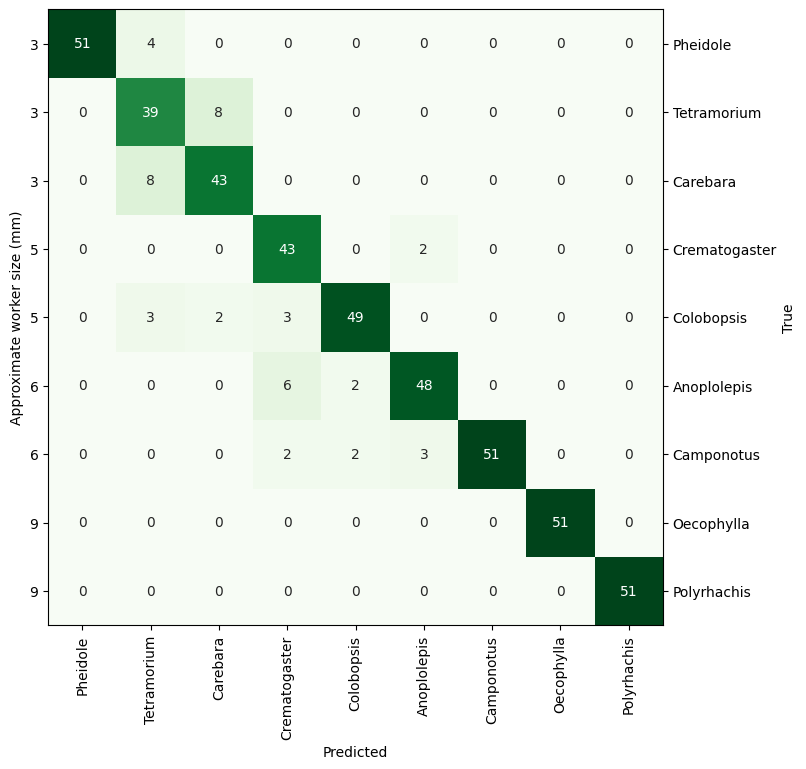

In [80]:
lda = LDA(n_components=4)
conf_matrix_H = pd.DataFrame(columns=list(range(1,1+len(labels))), index=list(range(1,1+len(labels))))
conf_matrix_H.loc[:,:] = 0

for index, row in data.iterrows():
    
        traindata = data.drop(index, axis=0)
        ytest = row['classInt']
        ytrain = traindata['classInt']
        Xtest = row.values[5:].astype(float)
        Xtrain = traindata.values[:,5:].astype(float)

        lda.fit_transform(Xtrain, ytrain) #main
        ypred = lda.predict(Xtest.reshape(1, -1))

        if ypred[0] in (1, 2, 3, 4) :
                
                lda = LDA(n_components=3)
                try:
                        traindata = datasmall.drop(index, axis=0)
                except:
                        traindata = datasmall
                
                ytest = row['classInt']
                ytrain = traindata['classInt']
                Xtest = row.values[5:].astype(float)
                Xtrain = traindata.values[:,5:].astype(float)

                lda.fit_transform(Xtrain, ytrain) #mini
                ypred = lda.predict(Xtest.reshape(1, -1))

                conf_matrix_H.at[ypred[0], ytest] = conf_matrix.at[ypred[0], ytest] +1 

        else:

                conf_matrix_H.at[ypred[0], ytest] = conf_matrix.at[ypred[0], ytest] +1 

                
fig = plt.figure(dpi=100, figsize=(11.6,8))
ax1 = fig.add_subplot(111)
ax1 = sns.heatmap(conf_matrix_H.to_numpy().astype(int), square=True, annot=True, fmt='d', cbar=False, cmap="Greens",
            xticklabels=labels, yticklabels=labels)
ticks = ax1.get_yticks()
ax2 = ax1.twinx()
ax2.set_yticks(ticks)
ax2.set_ylim([9 ,0])
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")
ax2.set_xlabel("3")
ax2.set_ylabel("Approximate worker size (mm)")
fig.subplots_adjust(left=0.37)
ax1.tick_params( labelright=True, labelbottom=True, labeltop=False, labelleft=False, labelrotation=0)
ax2.tick_params( labelright=False, labelbottom=False, labeltop=True, labelleft=True, labelrotation=0)
ax1.set_xticklabels((labels), rotation=90)
ax1.set_yticklabels(labels, rotation=00)
ax2.set_yticklabels(sizes, rotation=00)
ax1.xaxis.set_label_position('bottom')
ax1.yaxis.set_label_position('right')
ax2.xaxis.set_label_position('bottom')
ax2.yaxis.set_label_position('left')
# plt.savefig('matrxplot.png')
plt.show()



FINAL ACCURACIES

In [85]:
accuracy = np.trace(conf_matrix.to_numpy().astype(int))/(9*50)
accuracy_H = np.trace(conf_matrix_H.to_numpy().astype(int))/(9*50)

print("LDA accuracy = "+ str(accuracy))
print("Heirarchical LDA accuracy = "+ str(accuracy_H))


LDA accuracy = 0.7288888888888889
Heirarchical LDA accuracy = 0.9466666666666667
